# Cross Validation

In this notebook, I validate choices using cross validation.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

import aviary as av
import astropy.modeling as apm

from tqdm import trange
import pickle

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
class AgePosterior(object):

    def __init__(self, filename):
        
        # Load the saved GP gyro model
        with open(filename, "rb") as f:
            model, map_soln = pickle.load(f)

        # Pull out the model and parameters
        with model:
            func = xo.get_theano_function_for_var(model.y_test)
            args = xo.utils.get_args_for_theano_function(map_soln)
            ind1 = model.vars.index(model.x1_test)
            ind2 = model.vars.index(model.x2_test)
        
        self.func, self.args, self.ind1, self.ind2 = func, args, ind1, ind2

    def get_post(self, c, prot, prot_err, age_lim=[-3, 3]):
        """

        Args:
            c (float): color
            prot (float): prot (days)
            prot_err (float): absolute prot uncertainty (days)
        """

        self.args[self.ind2] = np.linspace(age_lim[0], age_lim[1], 5000)
        self.args[self.ind1] = c + np.zeros_like(self.args[self.ind2])

        posterior = np.exp(-0.5 * (self.func(*self.args) - np.log(prot))**2 / (prot_err / prot) ** 2)
        return np.exp(self.args[self.ind2]), posterior

In [17]:
def make_plot():
    # Format data for GP fit.
    inds = np.argsort(x)
    x1 = np.array(x[inds])
    x2 = np.log(np.array(age[inds]))
    y = np.log(np.array(prot[inds]))
    y_err = prot_err[inds]/prot[inds]

    x2_min = np.min(x2)
    xp1 = np.linspace(x1.min() - .2, x1.max() + .2, 1000)
    xg2 = np.array([np.log(.12), np.log(.67), np.log(1), np.log(1.6),
                    np.log(2.7), np.log(4.56), np.log(5), np.log(8),
                    np.log(10), np.log(14)])


    # Load the saved GP gyro model
    with open(filename, "rb") as f:
        model, map_soln = pickle.load(f)

    # Pull out the model and parameters
    with model:
        func = xo.get_theano_function_for_var(model.y_test)
        args = xo.utils.get_args_for_theano_function(map_soln)
        ind1 = model.vars.index(model.x1_test)
        ind2 = model.vars.index(model.x2_test)

    cmap = matplotlib.cm.get_cmap("plasma_r")

    vmin = np.exp(x2).min()
    vmax = np.exp(x2).max()

    def get_color(x2):
        return cmap((np.exp(x2) - vmin) / (vmax - vmin))

    plt.figure(figsize=(12, 7), dpi=200)
    plt.plot(kin.bprp_dered, kin.Prot, ".", color=".8", mec="none", ms=10, alpha=.2, zorder=0,
             label="$\mathrm{Field~Star~distribution}$")
    plt.scatter(x1, np.exp(y), c=np.exp(x2), vmin=vmin, vmax=vmax, s=8, cmap="plasma_r",
                label="$\mathrm{Kinematic~Ages~(Field~Stars)}$")
    plt.scatter(cluster_x, cluster_prot, c=cluster_age, vmin=vmin, vmax=vmax, s=20, edgecolor="k", cmap="plasma_r",
                label="$\mathrm{Cluster~Stars}$")
    
    for i in range(len(xg2)):
        plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
        plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

    plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
    plt.ylabel("$\mathrm{P_{rot}~[days]}$")
    plt.ylim(0.5, 180)
    plt.yscale("log")
    plt.colorbar(label="$\mathrm{Age~[Gyr]}$");
    plt.xlim(.5, 2.8)
    leg = plt.legend()
    leg.legendHandles[0]._legmarker.set_alpha(1)
    plt.tight_layout()

In [29]:
def RMS(ypred, yobs):
    return np.sqrt(sum((ypred - yobs)**2) / float(len(ypred)))

def MAD(ypred, yobs):
    return np.median(abs(ypred - yobs))

Variables to be optimized:

In [54]:
young_limit = 1. #.7
old_limit = 20.
hot_limit = 1.
dp, dc = .05, .05
cluster_old_err = .05  # The relative prot uncertainty on Ruprecht 147 and NGC6819
kinerr = .05 # The relative prot uncertainty on kinematic grid periods.
sun_err = .01  # The absolute prot uncertainty on the Sun's rotation period.

Load the kinematic data and create a grid over it.

In [55]:
k = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
k_lucy = pd.read_csv("../data/Gyrokinage2020_Prot.csv")
kl = pd.DataFrame(dict({"kepid": k_lucy.kepid.values,
                        "kin_age_lucy": k_lucy.kin_age.values,
                        "kin_age_err": k_lucy.kin_age_err.values}))
k = pd.merge(k, kl, on="kepid", how="left")

# Remove subgiants and photometric binaries
kin = k.iloc[k.flag.values == 1]
finite = np.isfinite(kin.Prot.values) & np.isfinite(kin.bprp_dered.values) & np.isfinite(kin.kin_age_lucy.values)
kin = kin.iloc[finite]

# Remove stars bluer than 1.5 and with kinematic ages greater than 6 as these are likely to be subgiants.
subs = (kin.bprp_dered.values < 1.5) & (kin.kinematic_age.values > 6)
kin = kin.iloc[~subs]

# Remove stars that fall beneath the lower envelope using the Angus + (2019) gyro relation and stars kinematically older than old_limit.
no_young = (kin.age.values > young_limit) & (kin.kin_age_lucy.values < old_limit)
kin = kin.iloc[no_young]

# Remove hot stars as the clusters provide better coverage.
cool = kin.bprp_dered.values > hot_limit
akin = kin.iloc[cool]

logp = np.log10(akin.Prot.values)
pgrid = np.arange(min(logp), max(logp), dp)
cgrid = np.arange(min(akin.bprp_dered.values), max(akin.bprp_dered.values), dc)
P, C = np.meshgrid(pgrid, cgrid)
A = np.zeros_like(P)
prot_errs, npoints = [np.zeros_like(P) for i in range(2)]
for i in range(np.shape(A)[0]):
    for j in range(np.shape(A)[1]):
        b = (logp - .5*dp < P[i, j]) & (P[i, j] < logp + .5*dp)
        b &= (akin.bprp_dered.values - .5*dc < C[i, j]) & (C[i, j] < akin.bprp_dered.values + .5*dc)
        A[i, j] = np.median(akin.kin_age_lucy.values[b])
        prot_errs[i, j] = np.sqrt(sum((akin.Prot_err.values[b]/akin.Prot.values[b])**2)) \
            / np.sqrt(float(len(akin.kin_age_lucy.values[b])))
        npoints[i, j] = len(akin.kin_age_lucy.values[b])

finite = np.isfinite(C) & np.isfinite(P) & np.isfinite(A) & np.isfinite(prot_errs)
morethan = npoints[finite] > 1
C, P, A, prot_errs = C[finite][morethan], P[finite][morethan], A[finite][morethan], prot_errs[finite][morethan]

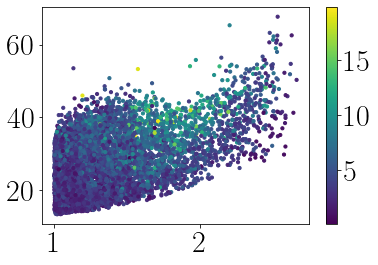

In [56]:
plt.scatter(akin.bprp_dered, akin.Prot, c=akin.kin_age_lucy, s=10)
plt.colorbar()

Load cluster data from Get_cluster_scatter and add the Sun.

In [57]:
cluster_uncert = pd.read_csv("../data/clusters_with_uncertainties.csv")
cluster_x = np.concatenate((cluster_uncert.bprp.values, np.array([0.82])))
cluster_prot = np.concatenate((cluster_uncert.prot.values, np.array([26])))
cluster_age = np.concatenate((cluster_uncert.age.values, np.array([4.56])))
cluster_prot_errs = np.concatenate((cluster_uncert.prot_err.values, np.array([sun_err])))

# Decrease the uncertainties on the oldest clusters to cluster_old_err
select_old = cluster_age > 2.
cluster_prot_errs[select_old] = np.ones(len(cluster_prot_errs[select_old])) * cluster_old_err

In [58]:
# Combine clusters with kinematic grid
x = np.concatenate((cluster_x, np.ndarray.flatten(C)))
prot_err = np.concatenate((cluster_prot_errs, np.ndarray.flatten(10**P)*kinerr))
prot = np.concatenate((cluster_prot, np.ndarray.flatten(10**P)))
age = np.concatenate((cluster_age, np.ndarray.flatten(A)))
ID = np.concatenate((np.zeros_like(cluster_age), np.ones_like(np.ndarray.flatten(A))))  # 0s are clusters, 1s are kinematics

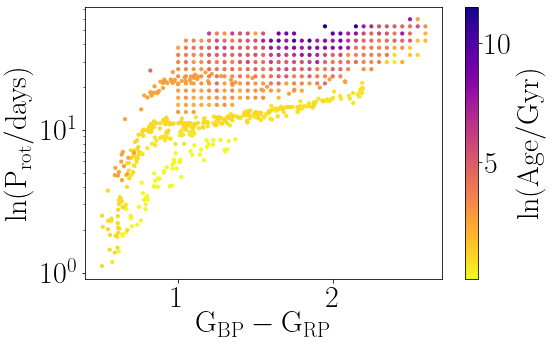

In [59]:
plt.figure(figsize=(8, 5))
plt.scatter(x, prot, c=age, s=10, cmap="plasma_r")
plt.xlabel("$$\mathrm{G_{BP}-G_{RP}}$$")
plt.ylabel("$\mathrm{ln(P_{rot}/days)}$")
plt.colorbar(label="$\mathrm{ln(Age/Gyr)}$")
plt.yscale("log")

First, let's see what the age residuals look like when you don't leave any stars out. Fit the model to all the data.

In [24]:
filename = "../data/CV_gp_model.pkl"
# Fit the GP gyro model
av.fit_gp(x, age, prot, prot_err, filename)
ap = AgePosterior(filename)

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1129.415348719169 -> -1125.3591675001921
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1125.3591675001921 -> -1124.7004444403915
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1124.7004444403915 -> -1122.6986352753802
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1122.6986352753802 -> -1120.8482727353658
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1120.8482727353658 -> 203.56259748650805
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 203.56259748650805 -> 216.50189377008883


done


What age do you infer for each star when you do this?

In [25]:
# Loop over stars.
mu, sig = [np.zeros(len(x)) for i in range(2)]
for i in trange(len(x)):

    # Get the age posterior
    age_array, posterior = ap.get_post(x[i], prot[i], prot_err[i])

    # Adopt MAP as mean
    mu[i] = age_array[posterior == max(posterior)]

    g_init = apm.models.Gaussian1D(amplitude=1., mean=mu[i], stddev=.5)
    fit_g = apm.fitting.LevMarLSQFitter()
    g = fit_g(g_init, age_array, posterior)
    _, sig[i] = g.mean.value, g.stddev.value

100%|██████████| 752/752 [00:59<00:00, 12.55it/s]


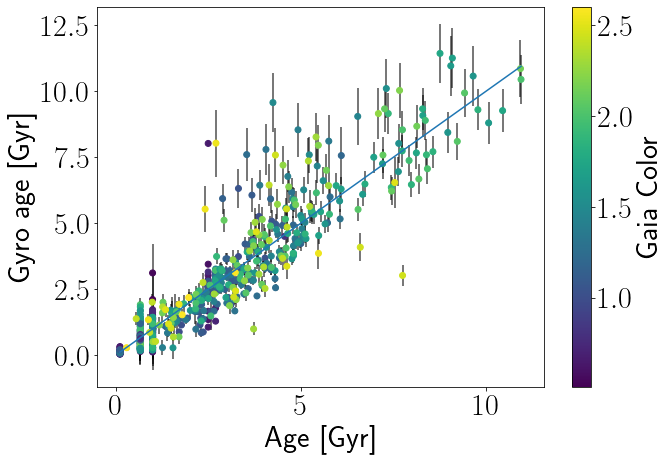

In [26]:
fig = plt.figure(figsize=(10, 7))
# plt.errorbar(age, mu-age, yerr=sig, fmt=".")
# plt.axhline(0, color="k", lw=.5)
plt.errorbar(age, mu, yerr=sig, fmt="k.", alpha=.7, zorder=0)
plt.scatter(age, mu, c=x)
xs = np.linspace(min(age), max(age), 100)
plt.plot(xs, xs)
plt.colorbar(label="Gaia Color")
plt.xlabel("Age [Gyr]")
plt.ylabel("Gyro age [Gyr]");

In [30]:
rms = RMS(age, mu)
mad = MAD(age, mu)
rms, mad

(0.8408739898745828, 0.3057444738201246)

In [31]:
bench_rms, bench_MAD = (0.8408739898745828, 0.3057444738201246)

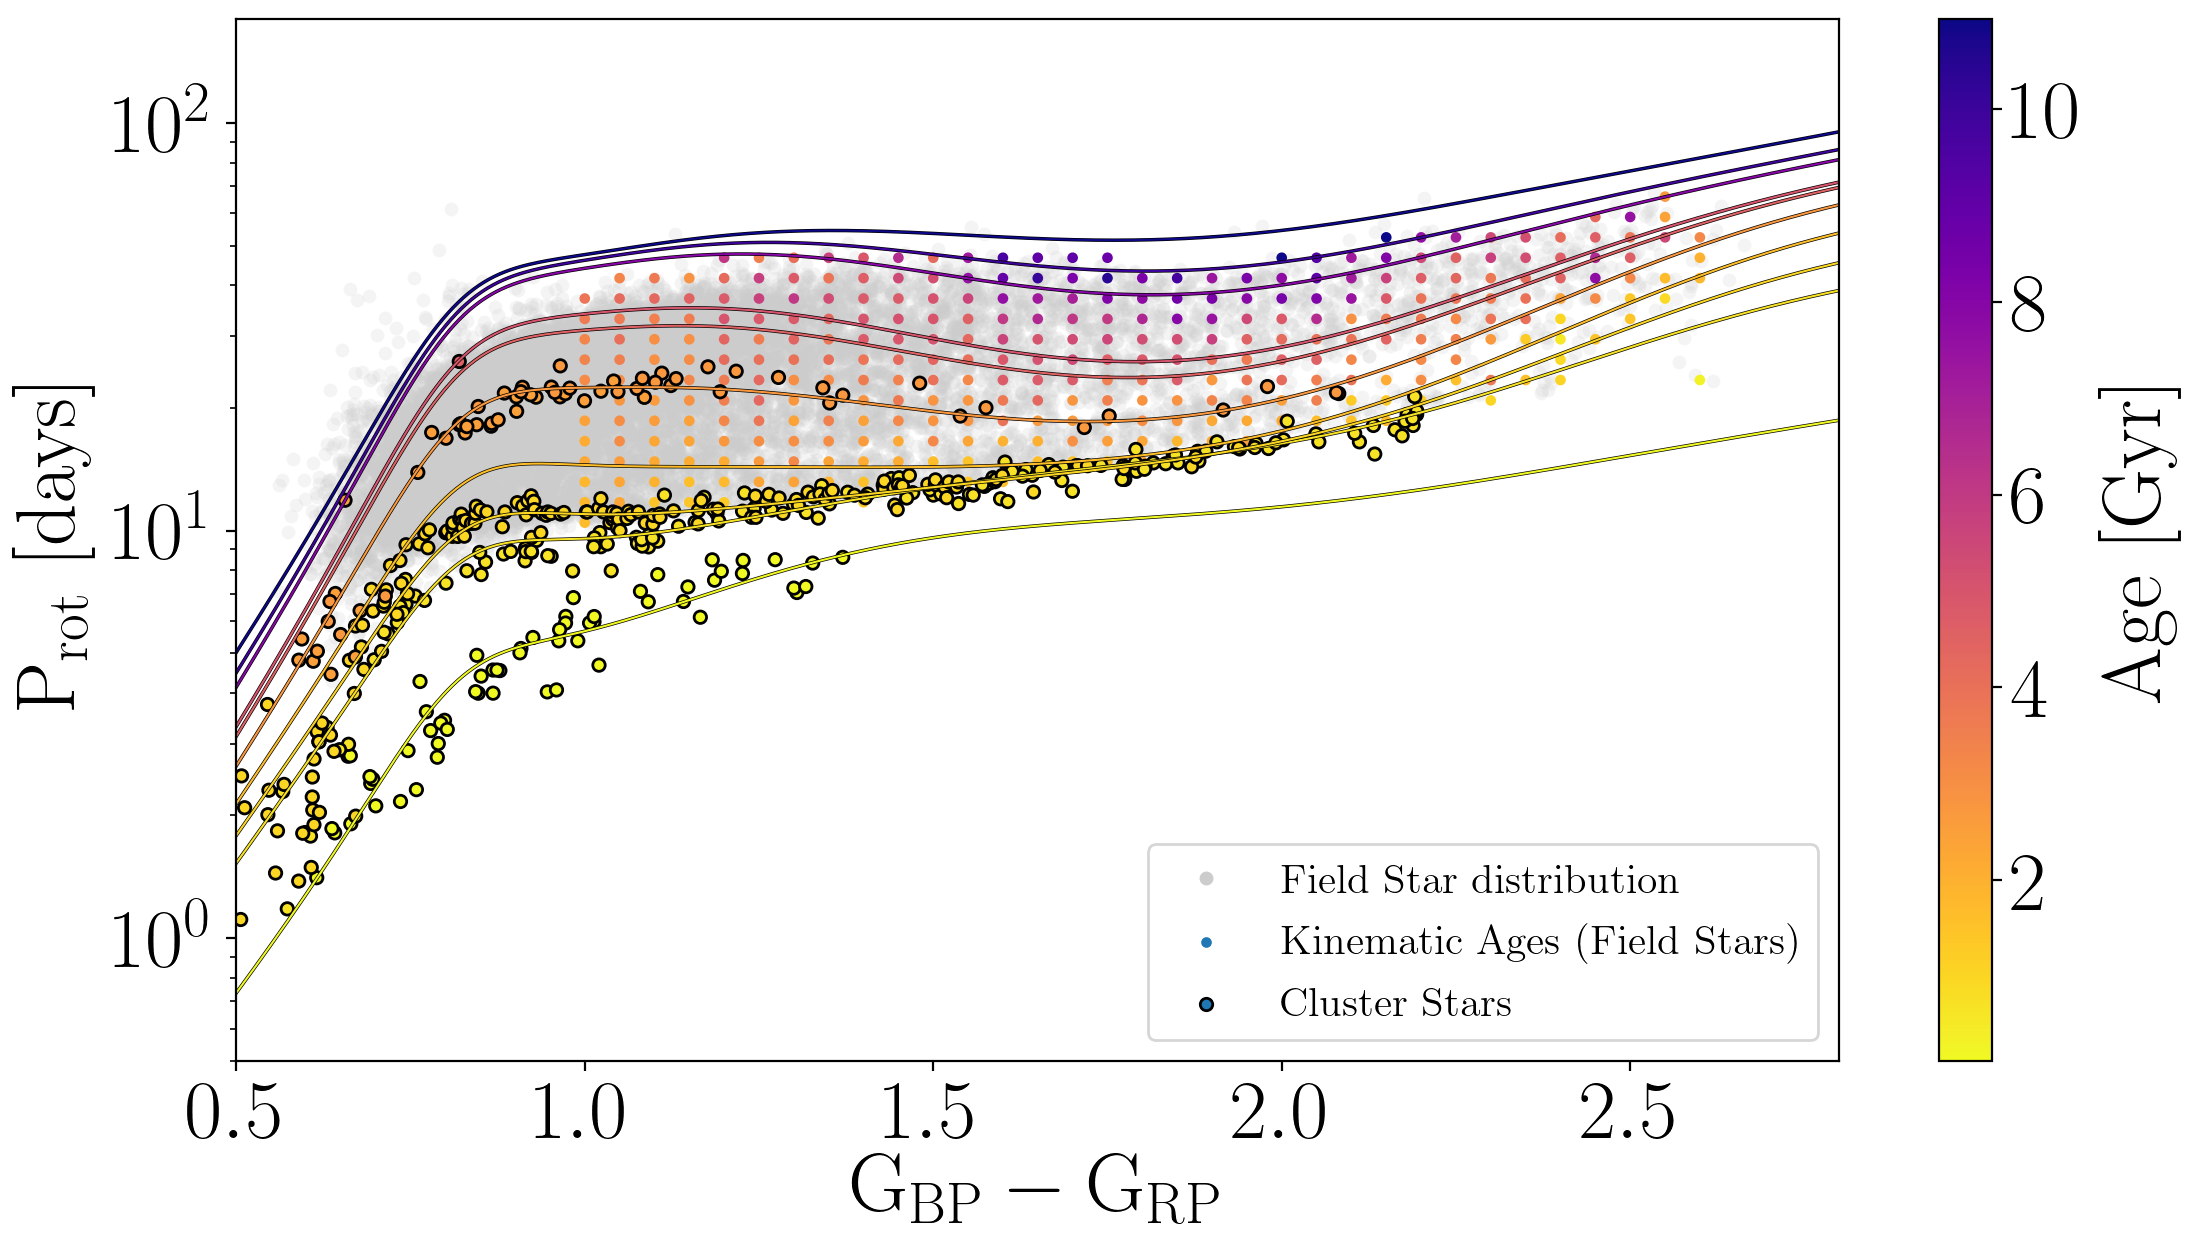

In [32]:
make_plot()

Pull out some data for cross validation and loop over cross validation batches.

In [142]:
# Pull some cluster data out for cross validation.
np.random.seed(42)
nbatches, nstars = 10, 10
ind_batches = [np.random.choice(np.arange(len(x)), nstars) for i in range(nbatches)]
all_true_ages, all_pred_ages, all_sig, all_ids = [], [], [], []

filename = "../data/CV_gp_model.pkl"
for i in range(nbatches):  # For each cross validation test
    
    # Divide into train and validate
    bools = np.ones(len(x), dtype="bool")
    bools[ind_batches[i]] = np.zeros(len(bools[ind_batches[i]]), dtype="bool")*1
    x_val, prot_val, prot_err_val, age_val, ID_val = x[ind_batches[i]], prot[ind_batches[i]], prot_err[ind_batches[i]], age[ind_batches[i]], ID[ind_batches[i]]
    _x, _prot, _prot_err, _age, _ID = x[bools], prot[bools], prot_err[bools], age[bools], ID[bools]
    
    # Fit the GP gyro model
    av.fit_gp(_x, _age, _prot, _prot_err, filename)
    
    # Load the age posterior model 
    ap = AgePosterior(filename)

    # Fit Gaussians to each star's age posterior
    mu, mu_fit, sig = [np.zeros(len(x_val)) for i in range(3)]
    for i in range(len(x_val)):
        age_array, posterior = ap.get_post(x_val[i], prot_val[i], prot_err_val[i])
#         age_array = np.log(lin_age_array)  # fit gaussian to log age?

        # Get mean and sigma of posterior. Adopt MAP as mu
        mu[i] = age_array[posterior == max(posterior)]

        g_init = apm.models.Gaussian1D(amplitude=1., mean=mu[i], stddev=.5)
        fit_g = apm.fitting.LevMarLSQFitter()
        g = fit_g(g_init, age_array, posterior)
        mu_fit[i], sig[i] = g.mean.value, g.stddev.value
    
    all_true_ages.append(age_val)
#     all_pred_ages.append(np.exp(mu))
    all_pred_ages.append(mu)
    all_sig.append(sig)
    all_ids.append(ID_val)

0
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1115.0109389611189 -> -1110.9771282172117
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.9771282172117 -> -1110.307096853559
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.307096853559 -> -1108.3181376449688
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3181376449688 -> -1106.4659856787441
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4659856787441 -> 200.93390760518426
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 200.93390760518426 -> 213.93208513514344


done
1
752 10
10
10


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9666658110593 -> -1110.924465326862
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.924465326862 -> -1110.2794271037285
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.2794271037285 -> -1108.292003402837
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.292003402837 -> -1106.4669148076982
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4669148076982 -> 197.08028474339505
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 197.08028474339505 -> 209.96912840322128


done
2
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9380639082742 -> -1110.900469097682
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.900469097682 -> -1110.2593322825762
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.2593322825762 -> -1108.2847370645313
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.2847370645313 -> -1106.4331026649782
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4331026649782 -> 197.70477894683148
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 197.70477894683148 -> 210.64436420445074


done


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


3
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.8236075967523 -> -1110.8103143782118
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.8103143782118 -> -1110.1599331101227
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.1599331101227 -> -1108.1386373111404
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.1386373111404 -> -1106.299224250222
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.299224250222 -> 205.13568341084505
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Desired error not necessarily achieved due to precision loss.
logp: 205.13568341084505 -> 218.29752477009308


done
4
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9908084771737 -> -1110.9560425864113
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.9560425864113 -> -1110.290383202108
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.290383202108 -> -1108.3102587696526
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3102587696526 -> -1106.4691914189093
INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4691914189093 -> 198.717040019488
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 198.717040019488 -> 211.67057227135024


done
5
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9865098961805 -> -1110.9614543510745
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.9614543510745 -> -1110.305162000496
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.305162000496 -> -1108.3161407937428
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3161407937428 -> -1106.4819535807137
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4819535807137 -> 197.9361720035526
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 197.9361720035526 -> 210.84022129227307


done
6
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


message: Optimization terminated successfully.
logp: -1114.8698423884275 -> -1110.8199589985063
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.8199589985063 -> -1110.1943895626337
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.1943895626337 -> -1108.1842581327621
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.1842581327621 -> -1106.3661302099715
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.3661302099715 -> 201.42807082935053
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 201.42807082935053 -> 213.94109422209598


done
7
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.8923078540536 -> -1110.8626187498046
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.8626187498046 -> -1110.2321695006171
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.2321695006171 -> -1108.2255603346582
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.2255603346582 -> -1106.4076114384236
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4076114384236 -> 208.6414955858067
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 208.6414955858067 -> 222.0980589238796


done
8
752 10
10
10


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.9646017338007 -> -1110.957659950133
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.957659950133 -> -1110.3119533382069
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.3119533382066 -> -1108.3224367359
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.3224367359 -> -1106.4988038796944
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.4988038796944 -> 199.0364951537459
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 199.0364951537459 -> 212.0158693424246


done
9
752 10
10
10


optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1114.8394675122229 -> -1110.727003662892
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1110.727003662892 -> -1110.0376581341795
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1110.0376581341795 -> -1108.1315030410356
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1108.1315030410356 -> -1106.3258382968966
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1106.3258382968966 -> 198.48500393088358
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 198.48500393088358 -> 212.29104858502794


done


INFO (theano.gof.compilelock): Refreshing lock /Users/rangus/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


Combine results from all batches.

In [143]:
ata = np.array([i for j in all_true_ages for i in j])
apa = np.array([i for j in all_pred_ages for i in j])
asig = np.array([i for j in all_sig for i in j])
ai = np.array([i for j in all_ids for i in j])

1.098236367174673


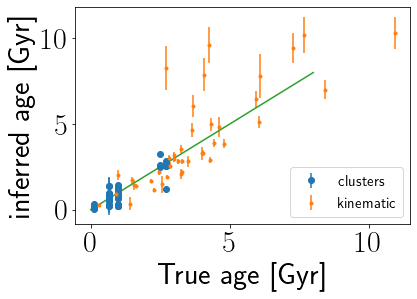

In [144]:
# Plot inferred vs. true age
plt.errorbar(ata[ai==0], apa[ai==0], yerr=asig[ai==0], fmt="o", label="clusters")
plt.errorbar(ata[ai==1], apa[ai==1], yerr=asig[ai==1], fmt=".", label="kinematic")
xs = np.linspace(0, 8, 100)
plt.plot(xs, xs)
plt.xlabel("True age [Gyr]")
plt.ylabel("inferred age [Gyr]")
plt.legend()
print(RMS(ata, apa))

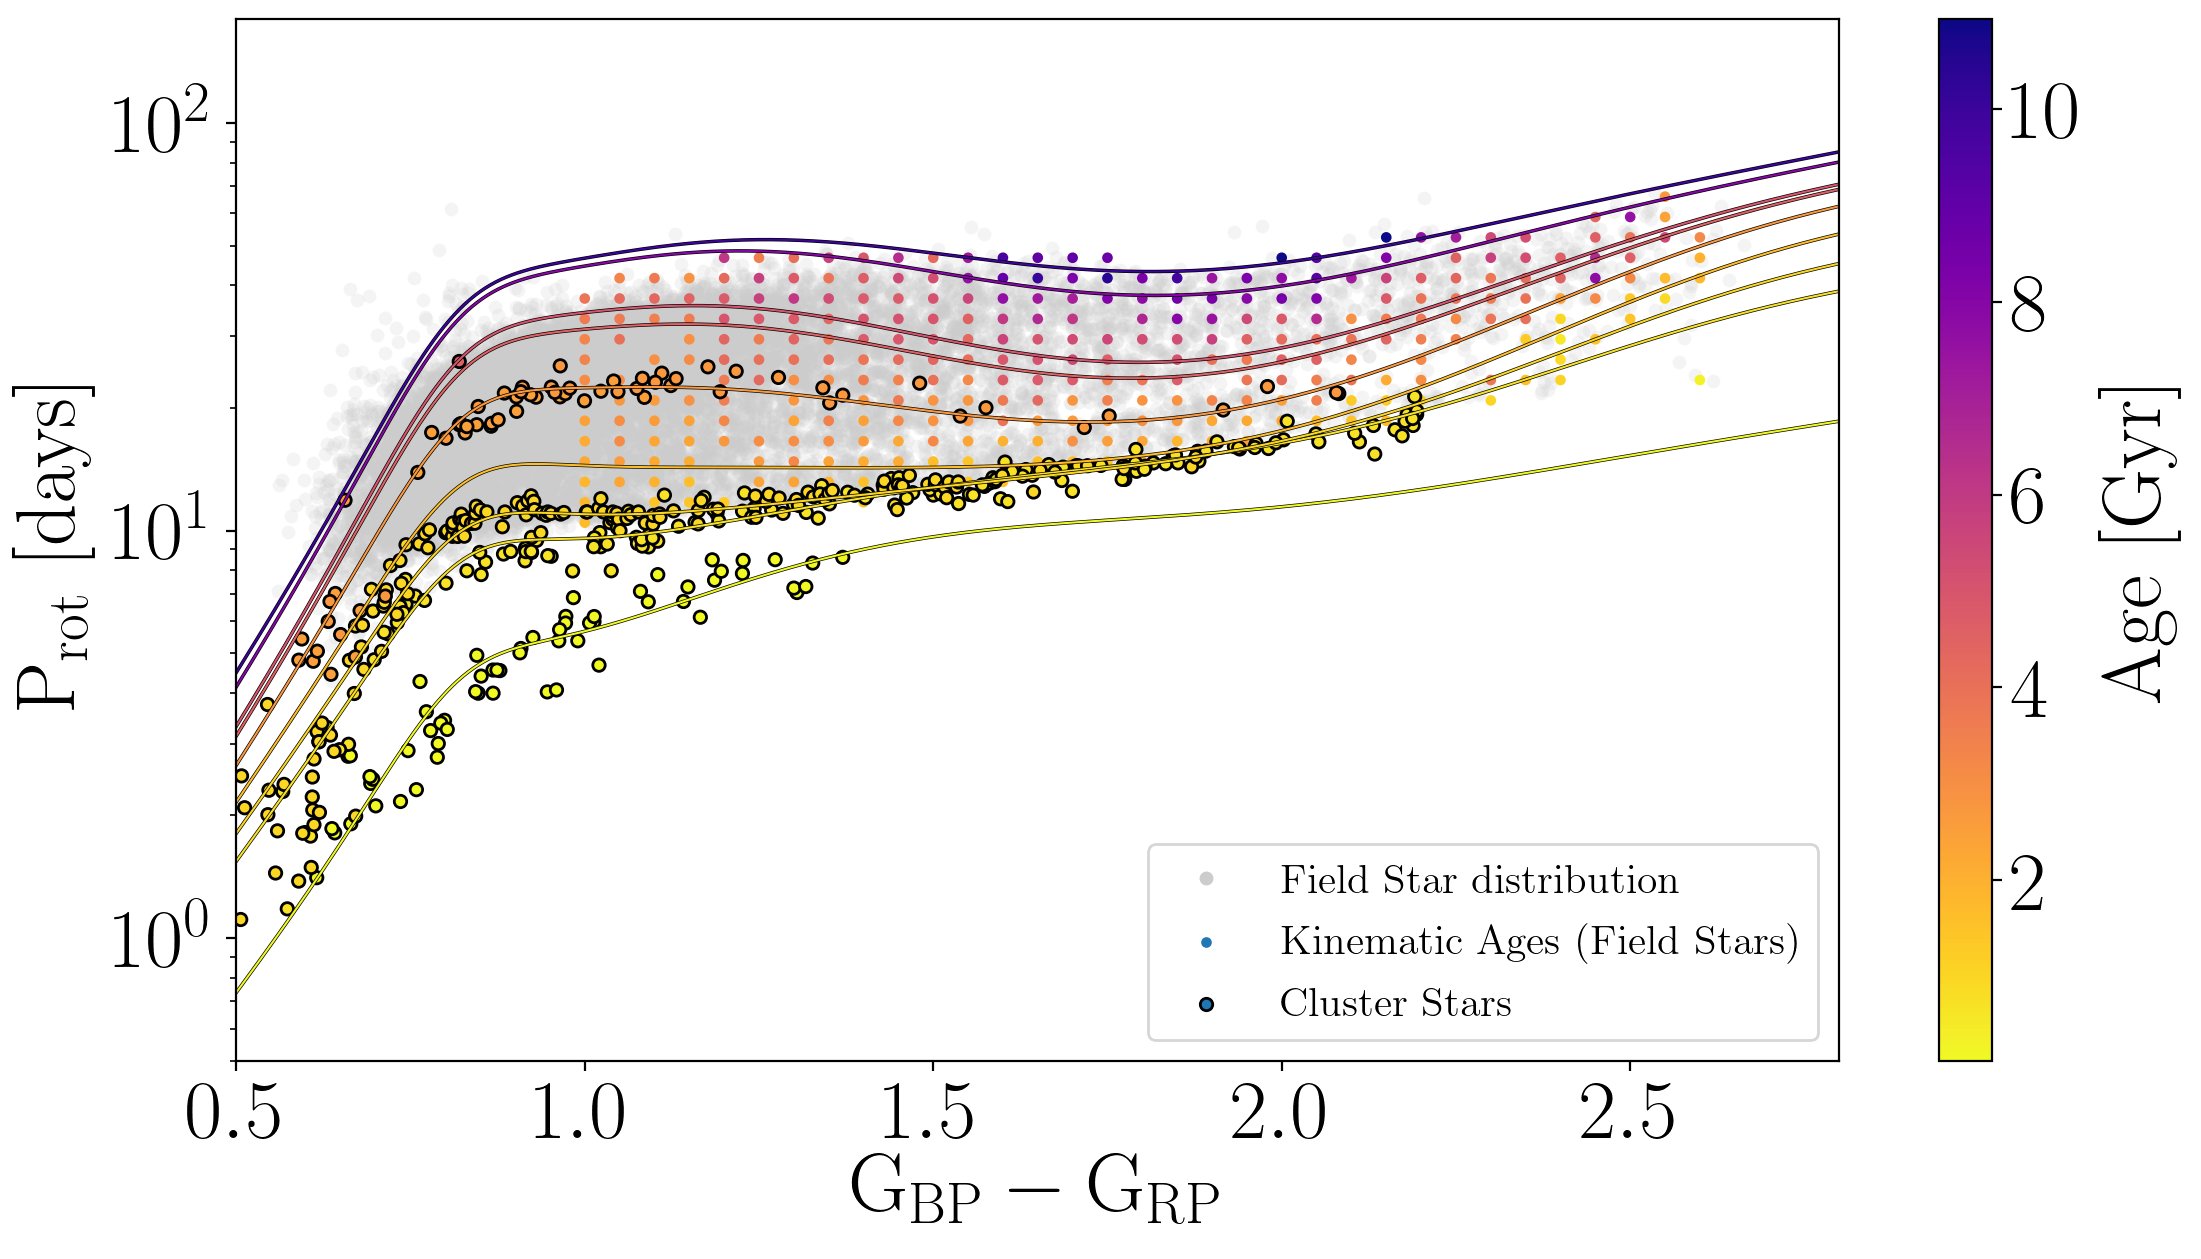

In [69]:
make_plot()